In [3]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:
def collect_data_and_plot(df, n_stores, n_warehouses, n_samples, test_mode, setting_name, underage_cost):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{n_stores}-{n_warehouses}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    lost_sales = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        batch_size = n_samples
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 50
            start_step = 30
        else:
            num_steps = 500
            start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]

        lost_sales.append(relevant_data['s_underage_costs'].sum() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].sum() / underage_cost)
        avg_w_holding.append(relevant_data['w_holding_costs'].sum() / underage_cost)
        avg_cost.append(relevant_data['s_underage_costs'].sum() + relevant_data['s_holding_costs'].sum() + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['lost_sales'] = lost_sales
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Calculate relative cost as percentage of minimum overall cost
    min_cost = df['avg_cost'].min()
    df['cost'] = df['avg_cost'] / min_cost * 100

    plot_data = df.pivot(columns='Architecture Class', 
                        values=['cost', 'lost_sales', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum)', 'Lost Sales (1e7)', 'Store Holding Cost (1e7)', 'Warehouse Holding Cost (1e7)']
    y_values = ['cost', 'lost_sales', 'avg_s_holding', 'avg_w_holding']
    scale_factors = [1, 1e-7, 1e-7, 1e-7]  # Unified scale factor of 1e7 for all metrics except cost

    for i, (ax, title, y_value, scale) in enumerate(zip(axes, titles, y_values, scale_factors)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy() * scale
                x_values = np.ones_like(plot_values)  # Create x values with same dimension as plot_values
                ax.plot(x_values, plot_values, marker='o', label=f'{arch}',
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks([]) # Remove x-axis ticks
    plt.tight_layout()
    plt.show()
    return df


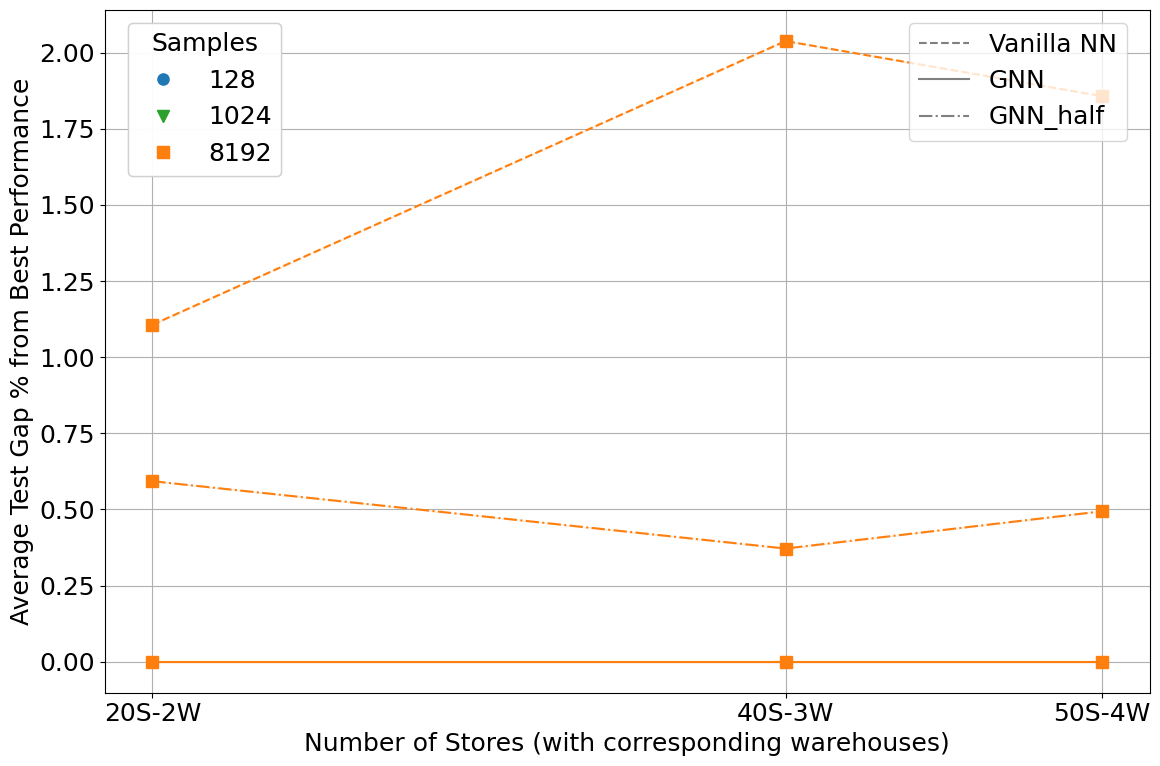

In [5]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_20_2", "n_warehouse_40_3", "n_warehouse_50_4"]
store_warehouse_pairs = {
    20: 2,
    40: 3,
    50: 4
}

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla NN": "--",  # Dashed
    "GNN": "-",         # Solid
    "GNN_half": "-.",    # Solid
}

# Define paths for each architecture
architectures = {
    "Vanilla NN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/vanilla_n_warehouses',
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN',
    "GNN_half": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_half',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define store sizes and sample sizes
store_sizes = [20, 40, 50]  # Corresponding to the testset names
sample_sizes = [8192]#128, 1024, 8192]

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        store_size = int(testset_name.split('_')[2])
        warehouse_size = store_warehouse_pairs[store_size]
        
        for sample_size in sample_sizes:
            if "GNN_half" == arch_name and sample_size != 8192:
                continue
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'samples': [1]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
                test_loss_limit = 100)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['n_warehouses'] = warehouse_size
            df['n_stores'] = store_size
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each store size
stats_by_arch_sample_and_stores = {}
for store_size in store_sizes:
    store_data = df[df['n_stores'] == store_size].copy()
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100
    
    for arch in store_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []
                
            sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                      (store_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': store_size,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(stores_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=8)
        
        plt.fill_between(stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)

# Create separate legend entries for architectures and sample sizes
arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=8)
                 for size in color_scheme.keys()]

plt.xlabel('Number of Stores (with corresponding warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Test Gap % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

# Create two separate legends
# Right legend for architectures
legend1 = plt.legend(handles=arch_lines, 
                    bbox_to_anchor=(0.99, 1),
                    loc='upper right', 
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

# Left legend for sample sizes with title
legend2 = plt.legend(handles=sample_patches,
                    title='Samples',
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

# Update x-axis ticks to show store-warehouse pairs
plt.xticks(store_sizes, [f'{s}S-{store_warehouse_pairs[s]}W' for s in store_sizes], fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [7]:
pd.DataFrame([
    {
        'Architecture': arch,
        'Sample Size': sample_size,
        'Stores': stats['n_stores'],
        'Mean Gap %': stats['mean_gap'],
        'CI Lower': stats['ci_lower'],
        'CI Upper': stats['ci_upper']
    }
    for (arch, sample_size), stats_list in stats_by_arch_sample_and_stores.items()
    for stats in stats_list
]).pivot_table(
    index=['Architecture', 'Sample Size'],
    columns='Stores',
    values='Mean Gap %',
    aggfunc='first'
).round(2)

Stores                       20     40     50
Architecture Sample Size                     
GNN          128           3.97   4.32   1.59
             1024          1.04   0.80   0.97
             8192          0.00   0.00   0.00
GNN_half     8192          0.59   0.37   0.49
Vanilla NN   128          12.08  14.21  15.15
             1024          3.51   6.28   6.71
             8192          1.11   2.04   1.86

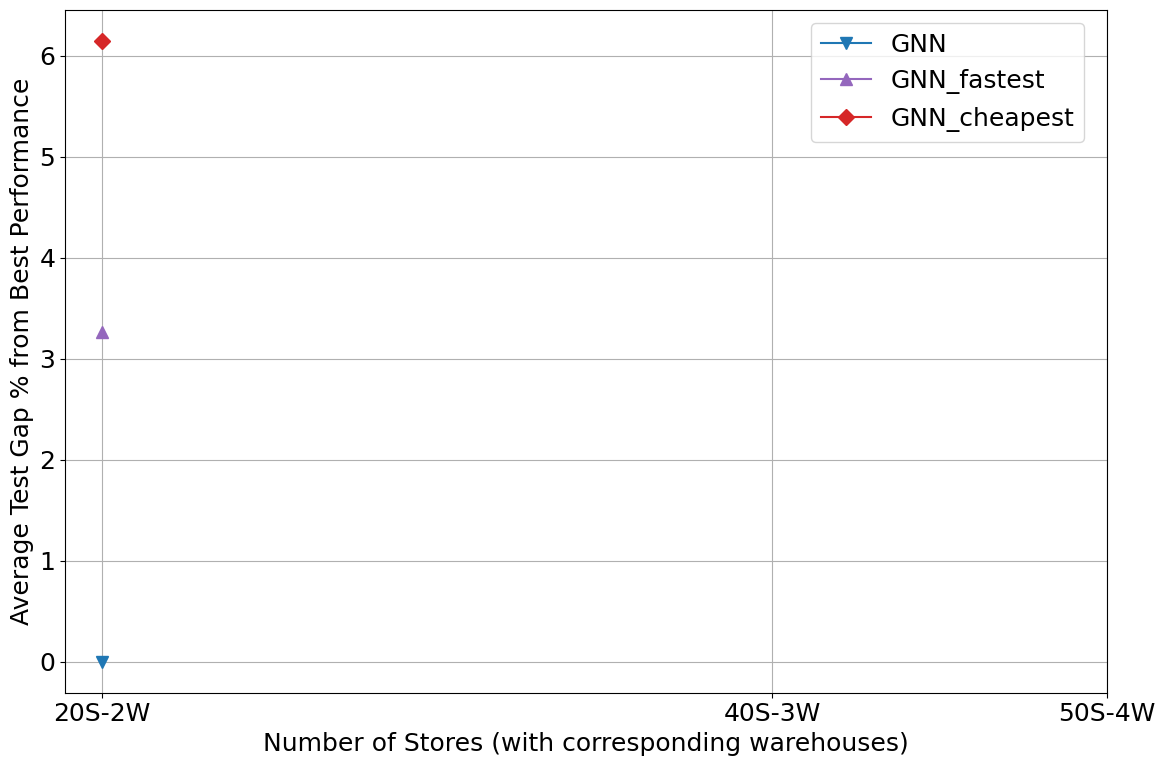

In [8]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_20_2"]# ["n_warehouse_20_2", "n_warehouse_40_3"]#, "n_warehouse_50_4"]
store_warehouse_pairs = {
    20: 2,
    40: 3,
    50: 4
}

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and markers
color_scheme = {
    "Vanilla NN": "#ff7f0e",    # Blue
    "GNN": "#1f77b4",          # Green  
    "GNN_fastest": "#9467bd",   # Purple
    "GNN_cheapest": "#d62728",  # Red
}

marker_scheme = {
    "Vanilla NN": "o",         # Circle
    "GNN": "v",               # Down triangle
    "GNN_fastest": "^",       # Up triangle
    "GNN_cheapest": "D",      # Diamond
}

# Define paths for each architecture
architectures = {
    # "Vanilla NN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/vanilla_n_warehouses',
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN',
    "GNN_fastest": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_fastest',
    "GNN_cheapest": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_cheapest',
}

architectures_hyperparam_names = {
    "GNN": "GNN",
    "GNN_fastest": "GNN_fastest",
    "GNN_cheapest": "GNN_cheapest",
    # "Vanilla NN": "vanilla_n_warehouses",
}


sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define store sizes and sample size
store_sizes = [20, 40, 50]  # Corresponding to the testset names
sample_size = 8192

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        store_size = int(testset_name.split('_')[2])
        warehouse_size = store_warehouse_pairs[store_size]
        
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': [sample_size],
             'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', architectures_hyperparam_names[arch_name])
        df['train_dev_sample_and_batch_size'] = sample_size
        df['n_warehouses'] = warehouse_size
        df['n_stores'] = store_size
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each store size
stats_by_arch_and_stores = {}
for store_size in store_sizes:
    store_data = df[df['n_stores'] == store_size].copy()
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100
    
    for arch in store_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_stores:
            stats_by_arch_and_stores[key] = []
            
        sample_data = store_data[store_data['Architecture Class'] == arch]
        if not sample_data.empty:
            gaps = sample_data['Gap %'].to_numpy()
            mean_gap = np.mean(gaps)
            std_gap = np.std(gaps)
            ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
            stats_by_arch_and_stores[key].append({
                'n_stores': store_size,
                'mean_gap': mean_gap,
                'ci_lower': mean_gap - ci_95,
                'ci_upper': mean_gap + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(stores_array, mean_gap_array,
                marker=marker_scheme[arch],
                color=color_scheme[arch],
                linestyle='-',
                markersize=8,
                label=arch)
        
        plt.fill_between(stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Stores (with corresponding warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Test Gap % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

# Create single legend for architectures
plt.legend(bbox_to_anchor=(0.99, 1),
          loc='upper right',
          fontsize=FONTSIZE)

# Update x-axis ticks to show store-warehouse pairs
plt.xticks(store_sizes, [f'{s}S-{store_warehouse_pairs[s]}W' for s in store_sizes], fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [7]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores
0,1,Vanilla NN,8192,Vanilla NN,1,0.0010,5.928485,5.909051,5.908074,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
1,1,GNN,8192,GNN,1,0.0010,5.810549,5.789231,5.790069,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
2,1,GNN_fastest,8192,GNN_fastest,1,0.0001,5.963241,5.921545,5.921975,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
3,1,GNN_cheapest,8192,GNN_cheapest,1,0.0010,6.027783,5.990966,5.991689,5,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40


In [ ]:
linestyle_scheme = {
    "GNN": "-",               # Solid
    "GNN_fastest": "-",      # Dash-dot
    "GNN_cheapest": "-",      # Dotted
    "Vanilla NN": "-",      # Dashed
}

collect_data_and_plot(df, 20, 2, 8192, "test", "n_warehouse_20_2_lost_demand", 9)

TypeError: collect_data_and_plot() missing 1 required positional argument: 'underage_cost'